In [6]:
!pip install catboost
!pip install optuna

In [7]:
import catboost as cb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import optuna
import pandas as pd
from pandas import read_csv

In [8]:
data = read_csv('dataset.csv')

In [9]:
y = data['response_att']
X = data.drop(columns=['response_att'])
X = X.filter(['group','perdelta_days_between_visits_15_30d',
 'k_var_days_between_visits_15d',
 'k_var_days_between_visits_1m',
 'k_var_days_between_visits_3m',
 'cheque_count_6m_g41',
 'cheque_count_6m_g40',
 'response_sms',
 'cheque_count_6m_g48',
 'cheque_count_12m_g38',
 'cheque_count_6m_g32',
 'response_viber',
 'k_var_count_per_cheque_6m_g27',
 'cheque_count_6m_g25',
 'cheque_count_12m_g32',
 'k_var_disc_share_15d_g24',
 'k_var_disc_share_6m_g24',
 'food_share_1m',
 'k_var_cheque_3m',
 'cheque_count_6m_g38',
 'cheque_count_3m_g25',
 'age',
 'food_share_15d',
 'cheque_count_12m_g41',
 'stdev_days_between_visits_15d',
 'k_var_sku_price_6m_g26'])
X.head()

,group,perdelta_days_between_visits_15_30d,k_var_days_between_visits_15d,k_var_days_between_visits_1m,k_var_days_between_visits_3m,cheque_count_6m_g41,cheque_count_6m_g40,response_sms,cheque_count_6m_g48,cheque_count_12m_g38,...,k_var_disc_share_6m_g24,food_share_1m,k_var_cheque_3m,cheque_count_6m_g38,cheque_count_3m_g25,age,food_share_15d,cheque_count_12m_g41,stdev_days_between_visits_15d,k_var_sku_price_6m_g26
0,1,1.3393,0.4554,0.6479,0.8240,1.0,5.0,0.923077,6.0,8.0,...,0.8036,0.3254,1.8741,4.0,8.0,47.0,0.6488,6.0,1.7078,0.1300
1,1,0.0000,0.0000,0.0000,1.0027,1.0,3.0,1.000000,1.0,1.0,...,0.0000,1.0000,0.9630,1.0,2.0,57.0,0.0000,1.0,0.0000,0.2072
2,0,0.0000,0.0000,0.0000,0.5559,8.0,7.0,1.000000,6.0,5.0,...,0.6608,0.4768,0.3295,1.0,3.0,38.0,0.3739,14.0,0.0000,0.0000
3,1,0.0000,0.0000,0.0000,0.7432,2.0,4.0,0.909091,3.0,14.0,...,0.0000,1.0000,1.4933,5.0,5.0,65.0,0.0000,8.0,0.0000,0.7469
4,1,0.0000,0.4714,0.4714,0.9980,2.0,8.0,1.000000,4.0,1.0,...,1.0710,0.2882,0.9014,1.0,1.0,61.0,0.2882,3.0,1.4142,1.0926


In [12]:
import numpy as np

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10)

X_test_0 = X_test.copy()
X_test_0['group'] = np.zeros(len(X_test_0['group']))
X_test_1 = X_test.copy()
X_test_1['group'] = np.ones(len(X_test_1['group']))

In [14]:
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.005, 0.015),
        "depth": trial.suggest_int("depth", 2, 5),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian"]
        ),
        "used_ram_limit": "9gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_uniform("bagging_temperature", 5, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)

    model = CatBoostClassifier(**param)
    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy

study = optuna.create_study()
study.optimize(objective, n_trials=25)
study.best_params

[I 2020-06-27 15:11:15,265] Finished trial#0 with value: 0.8949293820260154 with parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.011916141004285261, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.545771983791871}. Best is trial#0 with value: 0.8949293820260154.
[I 2020-06-27 15:13:00,485] Finished trial#1 with value: 0.894686791940187 with parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.012790276485976483, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.047818448605863}. Best is trial#1 with value: 0.894686791940187.
[I 2020-06-27 15:14:46,895] Finished trial#2 with value: 0.8951186022929615 with parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.014957754137558309, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.780805910890373}. Best is trial#1 with value: 0.894686791940187.
[I 2020-06-27 15:16:13,488]

{'objective': 'Logloss',
 'colsample_bylevel': 0.006154567921850269,
 'depth': 2,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 9.925679831491891}

In [15]:
model = CatBoostClassifier(
    objective=study.best_params['objective'],
    colsample_bylevel=study.best_params['colsample_bylevel'],
    depth=study.best_params['depth'],
    boosting_type=study.best_params['boosting_type'],
    bootstrap_type=study.best_params['bootstrap_type'],
    bagging_temperature=study.best_params['bagging_temperature'])
model.fit(X_train, y_train)

Learning rate set to 0.096195
0:	learn: 0.6187683	total: 135ms	remaining: 2m 14s
1:	learn: 0.5603447	total: 266ms	remaining: 2m 12s
2:	learn: 0.5145094	total: 401ms	remaining: 2m 13s
3:	learn: 0.4785294	total: 513ms	remaining: 2m 7s
4:	learn: 0.4502887	total: 647ms	remaining: 2m 8s
5:	learn: 0.4280968	total: 783ms	remaining: 2m 9s
6:	learn: 0.4106274	total: 912ms	remaining: 2m 9s
7:	learn: 0.3968441	total: 1.04s	remaining: 2m 8s
8:	learn: 0.3859427	total: 1.16s	remaining: 2m 8s
9:	learn: 0.3773007	total: 1.3s	remaining: 2m 8s
10:	learn: 0.3704338	total: 1.44s	remaining: 2m 9s
11:	learn: 0.3649917	total: 1.56s	remaining: 2m 8s
12:	learn: 0.3606222	total: 1.7s	remaining: 2m 8s
13:	learn: 0.3571491	total: 1.83s	remaining: 2m 9s
14:	learn: 0.3543457	total: 1.96s	remaining: 2m 8s
15:	learn: 0.3521017	total: 2.08s	remaining: 2m 8s
16:	learn: 0.3502972	total: 2.21s	remaining: 2m 8s
17:	learn: 0.3488395	total: 2.34s	remaining: 2m 7s
18:	learn: 0.3459097	total: 2.48s	remaining: 2m 7s
19:	learn:

158:	learn: 0.3197676	total: 19.6s	remaining: 1m 43s
159:	learn: 0.3197667	total: 19.7s	remaining: 1m 43s
160:	learn: 0.3197659	total: 19.9s	remaining: 1m 43s
161:	learn: 0.3197519	total: 20s	remaining: 1m 43s
162:	learn: 0.3197514	total: 20.1s	remaining: 1m 43s
163:	learn: 0.3197509	total: 20.3s	remaining: 1m 43s
164:	learn: 0.3197506	total: 20.4s	remaining: 1m 43s
165:	learn: 0.3197503	total: 20.5s	remaining: 1m 43s
166:	learn: 0.3196814	total: 20.7s	remaining: 1m 43s
167:	learn: 0.3196813	total: 20.8s	remaining: 1m 42s
168:	learn: 0.3196811	total: 20.9s	remaining: 1m 42s
169:	learn: 0.3196811	total: 21s	remaining: 1m 42s
170:	learn: 0.3196811	total: 21.1s	remaining: 1m 42s
171:	learn: 0.3196811	total: 21.3s	remaining: 1m 42s
172:	learn: 0.3196811	total: 21.4s	remaining: 1m 42s
173:	learn: 0.3196811	total: 21.5s	remaining: 1m 42s
174:	learn: 0.3196811	total: 21.6s	remaining: 1m 41s
175:	learn: 0.3196811	total: 21.7s	remaining: 1m 41s
176:	learn: 0.3196811	total: 21.9s	remaining: 1m 4

314:	learn: 0.3031375	total: 38.9s	remaining: 1m 24s
315:	learn: 0.3031375	total: 39s	remaining: 1m 24s
316:	learn: 0.3031375	total: 39.1s	remaining: 1m 24s
317:	learn: 0.3031375	total: 39.2s	remaining: 1m 24s
318:	learn: 0.3020905	total: 39.3s	remaining: 1m 23s
319:	learn: 0.3020902	total: 39.5s	remaining: 1m 23s
320:	learn: 0.3020901	total: 39.6s	remaining: 1m 23s
321:	learn: 0.3020899	total: 39.7s	remaining: 1m 23s
322:	learn: 0.3020898	total: 39.8s	remaining: 1m 23s
323:	learn: 0.3020897	total: 39.9s	remaining: 1m 23s
324:	learn: 0.3020897	total: 40.1s	remaining: 1m 23s
325:	learn: 0.3020897	total: 40.2s	remaining: 1m 23s
326:	learn: 0.3020897	total: 40.3s	remaining: 1m 23s
327:	learn: 0.3020897	total: 40.4s	remaining: 1m 22s
328:	learn: 0.3020897	total: 40.6s	remaining: 1m 22s
329:	learn: 0.3020897	total: 40.7s	remaining: 1m 22s
330:	learn: 0.3020897	total: 40.8s	remaining: 1m 22s
331:	learn: 0.3020897	total: 40.9s	remaining: 1m 22s
332:	learn: 0.3020897	total: 41s	remaining: 1m 2

470:	learn: 0.2968998	total: 58.2s	remaining: 1m 5s
471:	learn: 0.2968998	total: 58.3s	remaining: 1m 5s
472:	learn: 0.2968998	total: 58.4s	remaining: 1m 5s
473:	learn: 0.2964304	total: 58.5s	remaining: 1m 4s
474:	learn: 0.2964303	total: 58.7s	remaining: 1m 4s
475:	learn: 0.2964303	total: 58.8s	remaining: 1m 4s
476:	learn: 0.2964302	total: 58.9s	remaining: 1m 4s
477:	learn: 0.2964302	total: 59s	remaining: 1m 4s
478:	learn: 0.2964302	total: 59.2s	remaining: 1m 4s
479:	learn: 0.2957387	total: 59.3s	remaining: 1m 4s
480:	learn: 0.2957386	total: 59.4s	remaining: 1m 4s
481:	learn: 0.2957385	total: 59.5s	remaining: 1m 3s
482:	learn: 0.2956900	total: 59.7s	remaining: 1m 3s
483:	learn: 0.2956899	total: 59.8s	remaining: 1m 3s
484:	learn: 0.2956899	total: 59.9s	remaining: 1m 3s
485:	learn: 0.2956899	total: 1m	remaining: 1m 3s
486:	learn: 0.2956898	total: 1m	remaining: 1m 3s
487:	learn: 0.2956898	total: 1m	remaining: 1m 3s
488:	learn: 0.2956898	total: 1m	remaining: 1m 3s
489:	learn: 0.2956898	tota

628:	learn: 0.2939310	total: 1m 17s	remaining: 45.9s
629:	learn: 0.2939310	total: 1m 17s	remaining: 45.7s
630:	learn: 0.2939310	total: 1m 17s	remaining: 45.6s
631:	learn: 0.2939310	total: 1m 18s	remaining: 45.5s
632:	learn: 0.2939287	total: 1m 18s	remaining: 45.4s
633:	learn: 0.2939287	total: 1m 18s	remaining: 45.2s
634:	learn: 0.2939287	total: 1m 18s	remaining: 45.1s
635:	learn: 0.2939287	total: 1m 18s	remaining: 45s
636:	learn: 0.2939287	total: 1m 18s	remaining: 44.9s
637:	learn: 0.2939287	total: 1m 18s	remaining: 44.7s
638:	learn: 0.2939287	total: 1m 18s	remaining: 44.6s
639:	learn: 0.2939287	total: 1m 19s	remaining: 44.5s
640:	learn: 0.2937211	total: 1m 19s	remaining: 44.4s
641:	learn: 0.2937211	total: 1m 19s	remaining: 44.3s
642:	learn: 0.2937208	total: 1m 19s	remaining: 44.1s
643:	learn: 0.2937208	total: 1m 19s	remaining: 44s
644:	learn: 0.2937208	total: 1m 19s	remaining: 43.9s
645:	learn: 0.2937208	total: 1m 19s	remaining: 43.8s
646:	learn: 0.2937154	total: 1m 20s	remaining: 43.

784:	learn: 0.2921557	total: 1m 37s	remaining: 26.6s
785:	learn: 0.2921464	total: 1m 37s	remaining: 26.5s
786:	learn: 0.2921464	total: 1m 37s	remaining: 26.3s
787:	learn: 0.2921464	total: 1m 37s	remaining: 26.2s
788:	learn: 0.2921464	total: 1m 37s	remaining: 26.1s
789:	learn: 0.2921464	total: 1m 37s	remaining: 25.9s
790:	learn: 0.2921464	total: 1m 37s	remaining: 25.8s
791:	learn: 0.2921464	total: 1m 37s	remaining: 25.7s
792:	learn: 0.2921464	total: 1m 37s	remaining: 25.6s
793:	learn: 0.2921464	total: 1m 38s	remaining: 25.4s
794:	learn: 0.2921464	total: 1m 38s	remaining: 25.3s
795:	learn: 0.2921464	total: 1m 38s	remaining: 25.2s
796:	learn: 0.2921464	total: 1m 38s	remaining: 25.1s
797:	learn: 0.2921299	total: 1m 38s	remaining: 25s
798:	learn: 0.2921299	total: 1m 38s	remaining: 24.8s
799:	learn: 0.2921299	total: 1m 38s	remaining: 24.7s
800:	learn: 0.2921299	total: 1m 38s	remaining: 24.6s
801:	learn: 0.2921299	total: 1m 39s	remaining: 24.5s
802:	learn: 0.2921267	total: 1m 39s	remaining: 2

940:	learn: 0.2918284	total: 1m 56s	remaining: 7.28s
941:	learn: 0.2917695	total: 1m 56s	remaining: 7.16s
942:	learn: 0.2917695	total: 1m 56s	remaining: 7.04s
943:	learn: 0.2917684	total: 1m 56s	remaining: 6.91s
944:	learn: 0.2917684	total: 1m 56s	remaining: 6.79s
945:	learn: 0.2917684	total: 1m 56s	remaining: 6.67s
946:	learn: 0.2916554	total: 1m 56s	remaining: 6.54s
947:	learn: 0.2916554	total: 1m 57s	remaining: 6.42s
948:	learn: 0.2916554	total: 1m 57s	remaining: 6.3s
949:	learn: 0.2916554	total: 1m 57s	remaining: 6.17s
950:	learn: 0.2916554	total: 1m 57s	remaining: 6.05s
951:	learn: 0.2916554	total: 1m 57s	remaining: 5.93s
952:	learn: 0.2916554	total: 1m 57s	remaining: 5.8s
953:	learn: 0.2915114	total: 1m 57s	remaining: 5.68s
954:	learn: 0.2915114	total: 1m 57s	remaining: 5.55s
955:	learn: 0.2915114	total: 1m 58s	remaining: 5.43s
956:	learn: 0.2915114	total: 1m 58s	remaining: 5.31s
957:	learn: 0.2915114	total: 1m 58s	remaining: 5.18s
958:	learn: 0.2915114	total: 1m 58s	remaining: 5

In [16]:
X_test['uplift'] = model.predict_proba(X_test_1)[:,1] - model.predict_proba(X_test_0)[:,1]
X_test['response_att'] = y_test

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
def custom_metric(answers, take_top_ratio=0.25):
    answers.sort_values(by='uplift', inplace=True, ascending=False)
    
    n_samples = int(np.ceil(answers.shape[0] * take_top_ratio))
    answers = answers.iloc[:n_samples, :]
    answers_test = answers[answers['group'] == 1]['response_att'].sum() / \
                   answers[answers['group'] == 1].shape[0]
    answers_control = answers[answers['group'] == 0]['response_att'].sum() / \
                      answers[answers['group'] == 0].shape[0]
    return (answers_test - answers_control) * 100

In [18]:
from sklearn.metrics import accuracy_score

print(custom_metric(X_test, take_top_ratio=0.05))
print(accuracy_score(y_pred, y_test))
#print(np.sum(y_pred) / y_pred.shape[0])
#print(np.sum(y_test) / y_test.shape[0])

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1.7318128798575694


NameError: name 'y_pred' is not defined

In [19]:
! pip install seaborn

0


/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


100
200
300
400
500


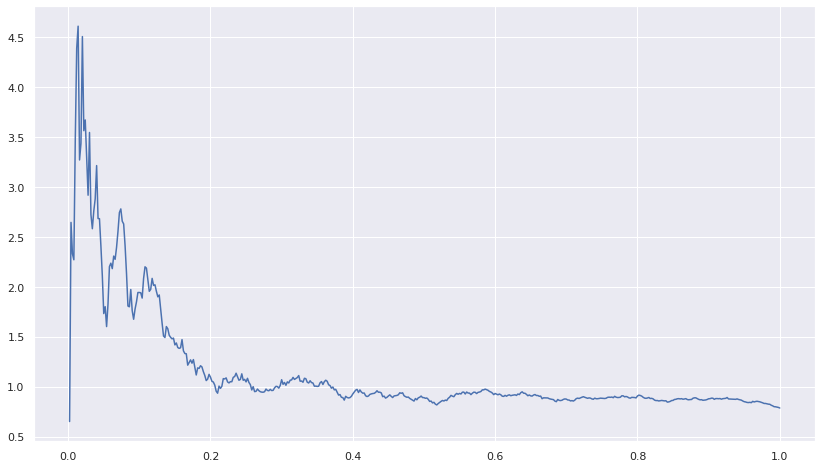

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")
x = []
answers = []
num = 500
for i in range(0, num + 1):
    if i % 100 == 0:
        print(i)
    x.append(1.0 * i / num)
    answers.append(custom_metric(X_test, take_top_ratio=1.0 * i/ num))
    
plt.figure(figsize=(14,8))
plt.plot(x, answers)

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


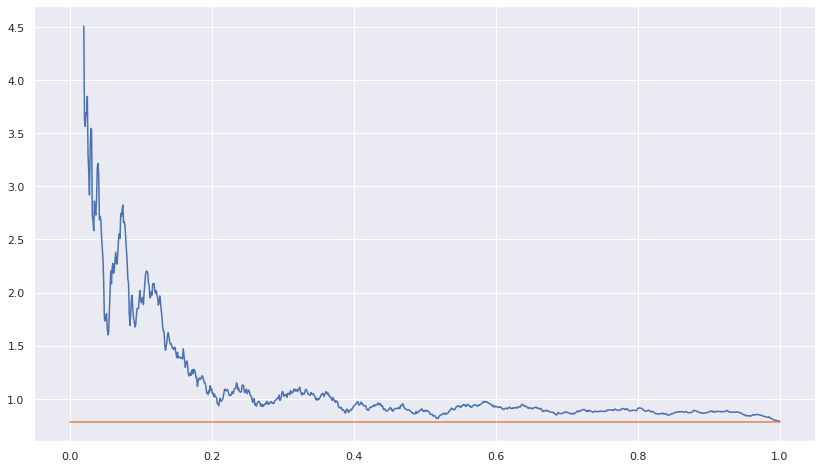

In [21]:
plt.figure(figsize=(14,8))
plt.plot(x, answers)
stupid = custom_metric(X_test, take_top_ratio=1.0)
plt.plot([0, 1], [stupid, stupid])
plt.show()

In [22]:
import gc
import pandas as pd
import numpy as np
from datetime import datetime

from xgboost import XGBClassifier
from sklift.models import ClassTransformation

from sklift.metrics import uplift_at_k
import matplotlib.pyplot as plt

%matplotlib inline

ModuleNotFoundError: No module named 'sklift'

In [ ]:
xgb_est_params = {
    'max_depth':2,
    'learning_rate': 0.2, 
    'n_estimators': 100,
    'nthread':40,
    'n_gpus':0,
    'seed':42
}

estimator = XGBClassifier(
    **xgb_est_params
)

uplift_model_cl_tr = ClassTransformation(
    estimator=estimator
)

In [ ]:
uplift_model_cl_tr.fit(
    X=X,
    y=y,
    treatment=df_train_feats['treatment_flg']
)

In [ ]:
df_feat_imp = pd.DataFrame([
    uplift_model_cl_tr\
        .estimator\
        .get_booster()\
        .get_score(importance_type='gain')
        ]
).T.reset_index()

df_feat_imp.columns =\
    ["feature", "value"]
    
df_feat_imp\
    .sort_values('value', ascending=False)